In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# for handling and parsing email files
import email
import os
import re
import nltk

from bs4 import BeautifulSoup
from collections import Counter

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
# load ham and spam files
ham_fnames = [name for name in sorted(os.listdir("Resources/main_ham"))]
spam_fnames = [name for name in sorted(os.listdir("Resources/main_spam"))]

In [3]:
# Creates a function that takes files in fnames variables and returns a parsed email
def parse_email(fname, spam=False):
    directory = "Resources/main_spam" if spam else "Resources/main_ham"
    with open(os.path.join(directory, fname), "rb") as fp:
        return email.parser.BytesParser().parse(fp)
        
ham_emails = [parse_email(name) for name in ham_fnames]
spam_emails = [parse_email(name, spam=True) for name in spam_fnames]

In [4]:
def html_to_text(email) -> str:
    try:
        soup = BeautifulSoup(email.get_payload(), "html.parser")
        plain = soup.text.replace("=\n", "")
        plain = re.sub(r"\s+", " ", plain)
        return plain.strip()
    except:
        return "nothing"

In [5]:
# General purpose function to convert an email to plain text
def email_to_text(email):
    text_content = ""
    for part in email.walk():
        part_content_type = part.get_content_type()
        if part_content_type not in ['text/plain', 'text/html']:
            continue
        if part_content_type == 'text/plain':
            text_content += part.get_payload()
        else:
            text_content += html_to_text(part)
    return text_content

print("Ham email in plain text:\n", email_to_text(ham_emails[3]))
print("Spam email in plain text:\n", email_to_text(spam_emails[3]))

Ham email in plain text:
 > From:  Valdis.Kletnieks@vt.edu
> Date:  Wed, 21 Aug 2002 02:36:56 -0400
>
> --==_Exmh_778588528P
> Content-Type: text/plain; charset=us-ascii
> 
> On Tue, 20 Aug 2002 22:51:52 EDT, Valdis.Kletnieks@vt.edu said:
> 
> > Ever tried to get MH to *not* have a 'pseq' sequence?  I suspect everybod
> y's
> > looking at a big box that has unseen and pseq in it.  Might want to add
> > 'pseq' to the 'hide by default' list....
> 
> Was it intended that if you added a sequence to the 'never show' list that
> it not take effect till you stopped and restarted exmh?  I added 'pseq',
> then hit 'save' for Preferences - didn't take effect till I restarted.

No it wasn't, and at one point it worked fine.  I'll check and see why it 
stopped working.

Chris
-- 
Chris Garrigues                 http://www.DeepEddy.Com/~cwg/
virCIO                          http://www.virCIO.Com
716 Congress, Suite 200
Austin, TX  78701		+1 512 374 0500

  World War III:  The Wrong-Doers Vs. the Evi

In [6]:
# transforms the email to count the word usage in the message
class EmailToWordsCount(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, to_lowercase=True, remove_punc=True, do_stem=True):
        self.strip_headers = strip_headers
        self.to_lowercase = to_lowercase
        self.remove_punc = remove_punc
        self.do_stem = do_stem
        
        # To perform stemming
        self.stemmer = nltk.PorterStemmer()
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_word_counts = []
        for email in X:
            # text of the email
            plain = email_to_text(email)
            if plain is None:
                plain = "nothing"
            
            if self.to_lowercase:
                plain = plain.lower()
            
            if self.remove_punc:
                plain = plain.replace(".", "")
                plain = plain.replace(",", "")
                plain = plain.replace("!", "")
                plain = plain.replace("?", "")
                plain = plain.replace(";", "")
                
            word_counts = Counter(plain.split())
            if self.do_stem:
                # Stem the word, and add their counts
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    root_word = self.stemmer.stem(word)
                    stemmed_word_counts[root_word] += count
                word_counts = stemmed_word_counts
            
            X_word_counts.append(word_counts)
        return np.array(X_word_counts)

In [7]:
#Build a Numpy matrix with the vocabulary of words to consider and their usage counts
class WordCountVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    # train on list of word counts and build vocabulary
    def fit(self, X, y=None):
        total_word_counts = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_word_counts[word] += count
                
        # Build a vocabulary out of total most common
        self.most_common = total_word_counts.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: i for i, (word, count) in enumerate(self.most_common)}
    
        return self
    # Create the vector out of vocabulary
    def transform(self, X, y=None):
        X_new = np.zeros([X.shape[0], self.vocabulary_size + 1], dtype=int)
        
        # The vectors will contain additional column for counts of words
        # not captured in vocabulary
        for row, word_counts in enumerate(X):
            for word, count in word_counts.items():
                col = self.vocabulary_.get(word, self.vocabulary_size)
                X_new[row, col] += count
                
        return X_new

In [8]:
email_to_cvector = Pipeline([
    ("emailToWords", EmailToWordsCount()), 
    ("wordCountVectorizer", WordCountVectorizer())
])

In [9]:
X = np.array(ham_emails + spam_emails, dtype='object')
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

In [10]:
print(type(X))

<class 'numpy.ndarray'>


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=3301)

print("Training set size: ", X_train.shape, y_train.shape)
print("Testing set size: ", X_test.shape, y_test.shape)

Training set size:  (7479,) (7479,)
Testing set size:  (1870,) (1870,)


In [12]:
# prepare the training and testing set 
X_train_prepared = email_to_cvector.fit_transform(X_train)
X_train_prepared

array([[  7,   6,   0, ...,   0,   0,  57],
       [  9,   7,   0, ...,   0,   0,  42],
       [  1,   5,   4, ...,   0,   0,  60],
       ...,
       [ 14,   9,   0, ...,   0,   0, 134],
       [ 33,  20,   0, ...,   1,   0, 125],
       [  0,   3,   0, ...,   0,   0,  17]])

In [13]:
X_test_prepared = email_to_cvector.transform(X_test)
X_test_prepared

array([[  2,   0,   0, ...,   0,   0,  37],
       [ 23,  21,   0, ...,   0,   0, 168],
       [  2,   3,   0, ...,   0,   0,  19],
       ...,
       [ 16,   7,   0, ...,   0,   0,  63],
       [ 31,  41,  33, ...,   0,   0, 164],
       [  0,   4,   0, ...,   0,   0,  22]])

In [20]:
def classification_models(model, X_train_prepared, X_test_prepared, y_train, y_test):
    model.fit(X_train_prepared, y_train)
    model_prediction = model.predict(X_test_prepared)
    
    print("Classification Report: ", classification_report(y_test, model_prediction))
    matrix = confusion_matrix(y_test, model_prediction)
    print("Confusion Matrix:", matrix)
    
    return matrix

models = [
    RandomForestClassifier(random_state=3301),
    LogisticRegression(solver="lbfgs", random_state=3301),
    DecisionTreeClassifier(random_state=3301)
]


In [34]:
# Initialize models
random_forest = RandomForestClassifier(random_state=3301)
logistic_regression = LogisticRegression(solver="lbfgs", random_state=3301)
decision_tree = DecisionTreeClassifier(random_state=3301)

# Generate confusion matrices for each model
matrix_rf = classification_models(random_forest, X_train_prepared, X_test_prepared, y_train, y_test)
matrix_lr = classification_models(logistic_regression, X_train_prepared, X_test_prepared, y_train, y_test)
matrix_dt = classification_models(decision_tree, X_train_prepared, X_test_prepared, y_train, y_test)

df_cm_rf = pd.DataFrame(matrix_rf, index=['ham', 'spam'], columns=['ham', 'spam'])
df_cm_lr = pd.DataFrame(matrix_lr, index=['ham', 'spam'], columns=['ham', 'spam'])
df_cm_dt = pd.DataFrame(matrix_dt, index=['ham', 'spam'], columns=['ham', 'spam'])

Classification Report:                precision    recall  f1-score   support

           0       0.99      0.99      0.99      1386
           1       0.98      0.96      0.97       484

    accuracy                           0.99      1870
   macro avg       0.98      0.98      0.98      1870
weighted avg       0.99      0.99      0.99      1870

Confusion Matrix: [[1378    8]
 [  19  465]]


/Users/sam/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:                precision    recall  f1-score   support

           0       0.98      0.99      0.99      1386
           1       0.97      0.95      0.96       484

    accuracy                           0.98      1870
   macro avg       0.97      0.97      0.97      1870
weighted avg       0.98      0.98      0.98      1870

Confusion Matrix: [[1370   16]
 [  25  459]]
Classification Report:                precision    recall  f1-score   support

           0       0.97      0.98      0.98      1386
           1       0.95      0.93      0.94       484

    accuracy                           0.97      1870
   macro avg       0.96      0.95      0.96      1870
weighted avg       0.97      0.97      0.97      1870

Confusion Matrix: [[1360   26]
 [  35  449]]


In [52]:
df_cm_rf

,ham,spam
ham,1378,8
spam,19,465


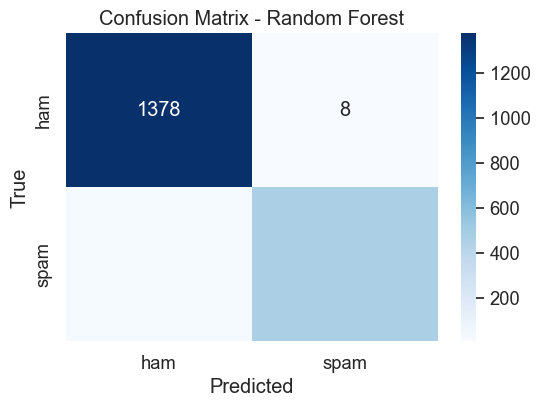

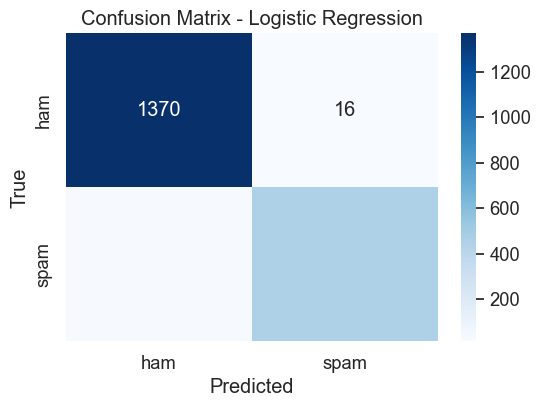

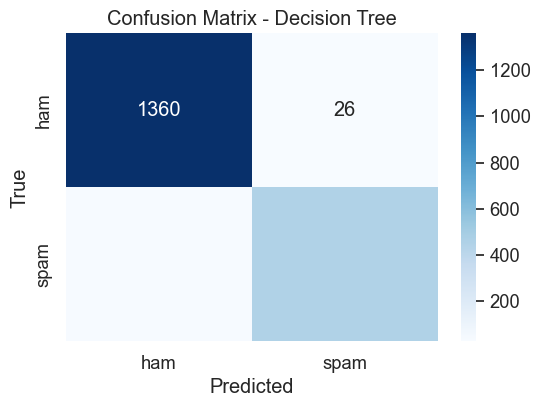

In [53]:
# Adjust plot settings to display full heatmap

# Visualize confusion matrix for Random Forest
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm_rf,annot=df_cm_rf, cmap='Blues', fmt='d')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Visualize confusion matrix for Logistic Regression
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm_lr, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Visualize confusion matrix for Decision Tree
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm_dt, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()